In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Считаем данные

In [2]:
from pyhdf.SD import SD, SDC

filtered_file_name = 'metm24_TA_251128_0101_9074_01_01A.hdf'
unfiltered_file_name = 'metm24_TA_251128_0101_9074_01_02A.hdf'

filtered_hdf = SD(filtered_file_name, SDC.READ)
unfiltered_hdf = SD(unfiltered_file_name, SDC.READ)

filtered_dataset = filtered_hdf.datasets()
unfiltered_dataset = unfiltered_hdf.datasets()

### Посмотрим структуру данных

In [3]:
filtered_dataset

{'m_m24_Julian Day_251128_A': (('YDimension', 'XDimension'), (1212, 1), 23, 0),
 'm_m24_Time of Day_UTC+3': (('YDimension', 'XDimension'), (1212, 1), 25, 1),
 'm_m24_Latitude': (('YDimension', 'fakeDim2'), (1212, 140), 5, 2),
 'm_m24_Longitude': (('YDimension', 'fakeDim3'), (1212, 140), 5, 3),
 'm_m24_SunZenith': (('YDimension', 'fakeDim4'), (1212, 140), 5, 4),
 'm_m24_SunAzimuth': (('YDimension', 'fakeDim5'), (1212, 140), 5, 5),
 'm_m24_Surface': (('YDimension', 'fakeDim6'), (1212, 140), 23, 6),
 'm_m24_01_10.6V': (('YDimension', 'fakeDim7'), (1212, 140), 23, 7),
 'm_m24_02_10.6H': (('YDimension', 'fakeDim8'), (1212, 140), 23, 8),
 'm_m24_03_18.7V': (('YDimension', 'fakeDim9'), (1212, 140), 23, 9),
 'm_m24_04_18.7H': (('YDimension', 'fakeDim10'), (1212, 140), 23, 10),
 'm_m24_05_23.8V': (('YDimension', 'fakeDim11'), (1212, 140), 23, 11),
 'm_m24_06_23.8H': (('YDimension', 'fakeDim12'), (1212, 140), 23, 12),
 'm_m24_07_36.7V': (('YDimension', 'fakeDim13'), (1212, 140), 23, 13),
 'm_m24

In [4]:
unfiltered_dataset

{'m_m24Julian Day_251128_A': (('YDimension', 'XDimension'), (1212, 1), 23, 0),
 'm_m24Time of Day_UTC+3': (('YDimension', 'XDimension'), (1212, 1), 25, 1),
 'm_m24Latitude': (('YDimension', 'fakeDim2'), (1212, 140), 5, 2),
 'm_m24Longitude': (('YDimension', 'fakeDim3'), (1212, 140), 5, 3),
 'm_m24SunZenith': (('YDimension', 'fakeDim4'), (1212, 140), 5, 4),
 'm_m24SunAzimuth': (('YDimension', 'fakeDim5'), (1212, 140), 5, 5),
 'm_m24Surface': (('YDimension', 'fakeDim6'), (1212, 140), 23, 6),
 'm_m2401_10.6V': (('YDimension', 'fakeDim7'), (1212, 140), 23, 7),
 'm_m2402_10.6H': (('YDimension', 'fakeDim8'), (1212, 140), 23, 8),
 'm_m2403_18.7V': (('YDimension', 'fakeDim9'), (1212, 140), 23, 9),
 'm_m2404_18.7H': (('YDimension', 'fakeDim10'), (1212, 140), 23, 10),
 'm_m2405_23.8V': (('YDimension', 'fakeDim11'), (1212, 140), 23, 11),
 'm_m2406_23.8H': (('YDimension', 'fakeDim12'), (1212, 140), 23, 12),
 'm_m2407_36.7V': (('YDimension', 'fakeDim13'), (1212, 140), 23, 13),
 'm_m2408_36.7H': (('

Одни и те же изображения называются по разному в двух файлах, что просто отвратительно 😠 <br>
- `m_m24_13_53_80V` <- название в фильтрованном наборе данных
- `m_m2413_53_80V` <- название в нефильтрованном наборе данных

### Визуализация наших изображений

In [5]:
from matplotlib.colors import PowerNorm, LogNorm

def plot_filtered_vs_unfiltered(filtered_file, unfiltered_file, 
                                filtered_var_name,
                                unfiltered_var_name,
                                lower_percentile=2,
                                upper_percentile=98,
                                cmap="inferno",
                                norm_type="linear",
                                gamma=0.5):
    """
    Plot the same channel from filtered and unfiltered HDF4 files side-by-side.

    Parameters
    ----------
    filtered_file : str
        Path to filtered .hdf file
    unfiltered_file : str
        Path to unfiltered .hdf file
    filtered_var_name : str
        Filtered dataset name, e.g. 'm_m24_13_53_80V'
    unfiltered_var_name : str
        Unfiltered dataset name, e.g. 'm_m2413_53_80V'
    vmin, vmax : float or None
        Color scale limits
    cmap : str
        Matplotlib colormap
    norm_type: str
        "linear", "log", or "power"
    gamma: float
        Used only for 'power' normalization
    """

    # --- open files ---
    f_filt = SD(filtered_file, SDC.READ)
    f_unf  = SD(unfiltered_file, SDC.READ)

    # --- read datasets ---
    data_filt = f_filt.select(filtered_var_name).get()
    data_unf  = f_unf.select(unfiltered_var_name).get()

    # convert to float for safety
    data_filt = np.array(data_filt, dtype=float)
    data_unf  = np.array(data_unf, dtype=float)

    # --- percentile-based vmin / vmax ---
    all_data = np.concatenate([data_filt.ravel(), data_unf.ravel()])
    vmin = np.percentile(all_data, lower_percentile)
    vmax = np.percentile(all_data, upper_percentile)

    # --- choose normalization ---
    if norm_type == "log":
        norm = LogNorm(vmin=max(vmin, 1e-6), vmax=vmax)
    elif norm_type == "power":
        norm = PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)
    else:  # linear
        norm = None

    # --- plot ---
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    im0 = axes[0].imshow(data_unf, vmin=vmin, vmax=vmax, cmap=cmap, aspect="auto")
    axes[0].set_title(f"UNFILTERED\n{unfiltered_var_name}")
    axes[0].set_xlabel("X")
    axes[0].set_ylabel("Y")

    im1 = axes[1].imshow(data_filt, vmin=vmin, vmax=vmax, cmap=cmap, aspect="auto")
    axes[1].set_title(f"FILTERED\n{filtered_var_name}")
    axes[1].set_xlabel("X")
    axes[1].set_ylabel("Y")

    fig.colorbar(im0, ax=axes, orientation="vertical", fraction=0.02)
    # plt.tight_layout()
    plt.show()

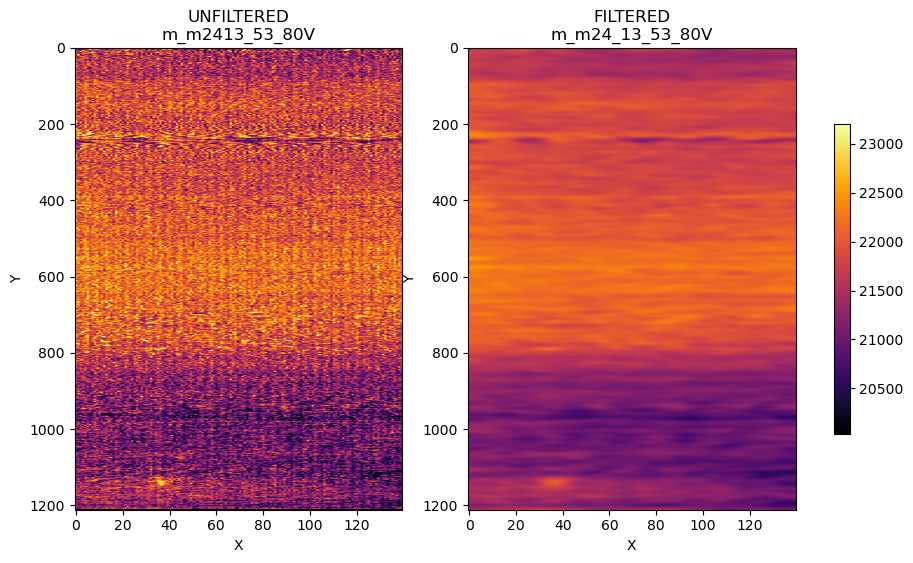

In [6]:
plot_filtered_vs_unfiltered(
    "metm24_TA_251128_0101_9074_01_01A.hdf",
    "metm24_TA_251128_0101_9074_01_02A.hdf",
    "m_m24_13_53_80V",
    "m_m2413_53_80V"
)


### Подход к снаряду № 1. Обучаем небольшой U-Net

In [7]:
# requirements: torch torchvision h5py numpy pyhdf tqdm
import os, math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pyhdf.SD import SD, SDC
from tqdm import tqdm

# --- simple U-Net ---
class UNetSmall(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=32):
        super().__init__()
        def conv_block(in_c, out_c):
            return nn.Sequential(nn.Conv2d(in_c, out_c, 3, padding=1),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(out_c, out_c, 3, padding=1),
                                 nn.ReLU(inplace=True))
        self.enc1 = conv_block(in_ch, base)
        self.pool = nn.MaxPool2d(2)
        self.enc2 = conv_block(base, base*2)
        self.enc3 = conv_block(base*2, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = conv_block(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = conv_block(base*2, base)
        self.final = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d2 = self.up2(e3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        out = self.final(d1)
        return out

# --- Dataset: tiles from HDF pairs ---
class SwathTileDataset(Dataset):
    def __init__(self, unfiltered_hdf, filtered_hdf, 
                 unfiltered_varname, filtered_varname, 
                 tile_h=128, tile_w=256, transforms=None):
        self.unf = SD(unfiltered_hdf, SDC.READ).select(unfiltered_varname).get().astype(np.float32)
        self.filt = SD(filtered_hdf, SDC.READ).select(filtered_varname).get().astype(np.float32)
        assert self.unf.shape == self.filt.shape
        self.H, self.W = self.unf.shape
        self.tile_h = tile_h
        self.tile_w = tile_w
        self.transforms = transforms
        # create tile top-left coords (stride = tile size // 2)
        stride_h = tile_h // 2
        stride_w = tile_w // 2
        coords = []
        for y in range(0, max(1, self.H - tile_h + 1), stride_h):
            for x in range(0, max(1, self.W - tile_w + 1), stride_w):
                coords.append((y, x))
        self.coords = coords

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        y, x = self.coords[idx]
        a = self.unf[y:y+self.tile_h, x:x+self.tile_w]
        b = self.filt[y:y+self.tile_h, x:x+self.tile_w]
        # normalize per-tile (or use global mean/std)
        mean = np.mean(a)
        std = np.std(a) if np.std(a) > 0 else 1.0
        a_n = (a - mean) / std
        b_n = (b - mean) / std
        # to tensor (C,H,W)
        a_t = torch.from_numpy(a_n[None,:,:].astype(np.float32))
        b_t = torch.from_numpy(b_n[None,:,:].astype(np.float32))
        return a_t, b_t

# --- training loop (very minimal) ---
def train_unet(unf_hdf, filt_hdf, unfiltered_varname, filtered_varname, out_model='unet.pth', epochs=20, batch=32, device='cpu'):
    ds = SwathTileDataset(unf_hdf, filt_hdf, unfiltered_varname, filtered_varname)
    dl = DataLoader(ds, batch_size=batch, shuffle=True, num_workers=4, pin_memory=True)
    model = UNetSmall(1,1).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.L1Loss()
    for ep in range(epochs):
        model.train()
        running = 0.0
        for a,b in tqdm(dl, desc=f"ep{ep}"):
            a = a.to(device); b = b.to(device)
            out = model(a)
            loss = loss_fn(out, b)
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item() * a.size(0)
        print(f"Epoch {ep} loss: {running/len(ds):.4f}")
        torch.save(model.state_dict(), out_model)
    return model


In [ ]:
unet_model = train_unet(unfiltered_file_name, 
                        filtered_file_name, 
                        "m_m2413_53_80V",
                        "m_m24_13_53_80V")

ep0:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

### Подход к снаряду №2: Median Filter

In [7]:
from scipy.ndimage import median_filter

WINDOW_SIZE = 5   

In [8]:
filtered_file_name = 'metm24_TA_251128_0101_9074_01_01A.hdf'
unfiltered_file_name = 'metm24_TA_251128_0101_9074_01_02A.hdf'

filtered_var_name = "m_m24_13_53_80V"
unfiltered_var_name = "m_m2413_53_80V"

f_filt = SD(filtered_file_name, SDC.READ)
f_unf = SD(unfiltered_file_name, SDC.READ)

data_filt = f_filt.select(filtered_var_name).get()
data_unf = f_unf.select(unfiltered_var_name).get()

data_filt = np.array(data_filt, dtype=np.float32)
data_unf = np.array(data_unf, dtype=np.float32)

print("Image shape:", data_unf.shape)
print("Data type:", data_unf.dtype)

Image shape: (1212, 140)
Data type: float32


In [9]:
filtered_image = median_filter(data_unf, size=WINDOW_SIZE)

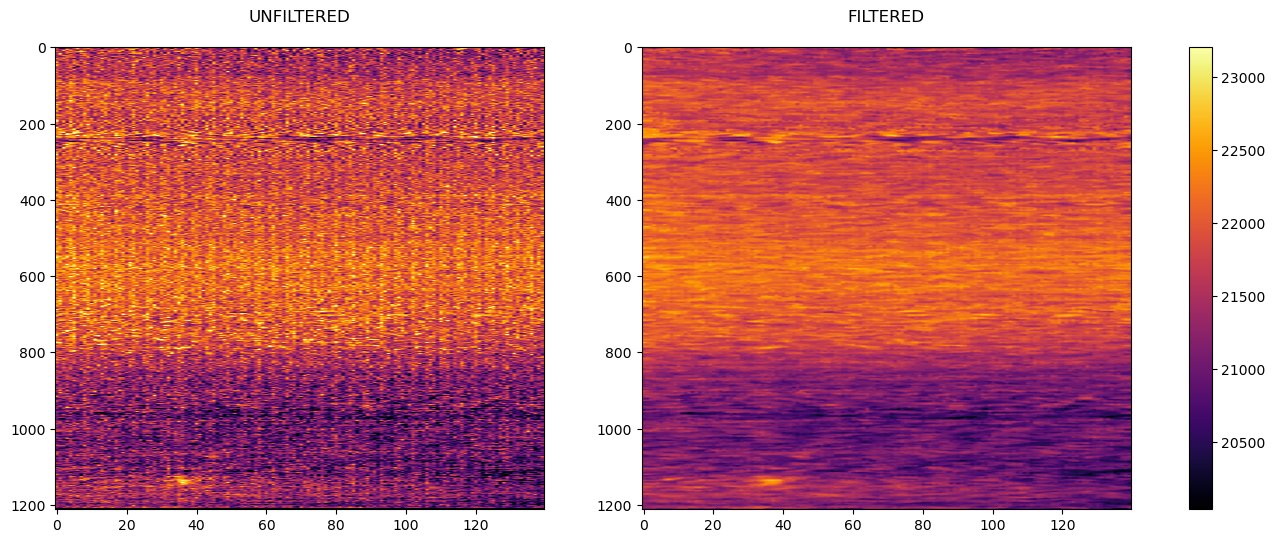

In [10]:
# --- percentile-based vmin / vmax ---
norm_type = None
lower_percentile=2
upper_percentile=98
cmap="inferno"
data_filt = filtered_image
all_data = np.concatenate([data_filt.ravel(), data_unf.ravel()])
vmin = np.percentile(all_data, lower_percentile)
vmax = np.percentile(all_data, upper_percentile)

# --- choose normalization ---
if norm_type == "log":
    norm = LogNorm(vmin=max(vmin, 1e-6), vmax=vmax)
elif norm_type == "power":
    norm = PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)
else:  # linear
    norm = None

# --- plot ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

im0 = axes[0].imshow(data_unf, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm, aspect="auto")
axes[0].set_title(f"UNFILTERED\n")

im1 = axes[1].imshow(data_filt, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm, aspect="auto")
axes[1].set_title(f"FILTERED\n")

fig.colorbar(im0, ax=axes, fraction=0.025)
# plt.tight_layout()
plt.show()

### Подход к снаряду №3: Block-matching and 3D filtering

Normalized range: 0.0 to 1.0
Estimated noise sigma: 0.17369


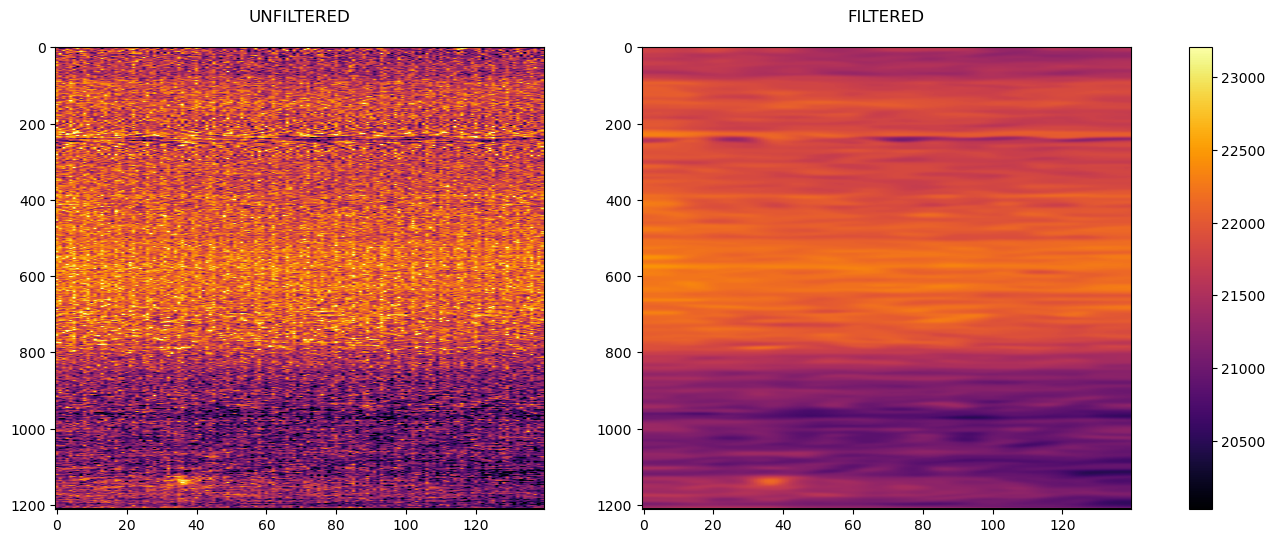

In [11]:
import matplotlib.pyplot as plt
from bm3d import bm3d
from scipy.ndimage import convolve

# ======================
# NORMALIZE IMAGE TO [0,1]
# ======================

min_val = np.min(data_unf)
max_val = np.max(data_unf)

image_norm = (data_unf - min_val) / (max_val - min_val + 1e-8)

print("Normalized range:", image_norm.min(), "to", image_norm.max())

# ======================
# APPLY BM3D
# ======================

# =====================
# AUTO NOISE ESTIMATION
# =====================

def estimate_noise_sigma(image):
    H = np.array([[1, -2, 1],
                  [-2, 4, -2],
                  [1, -2, 1]])

    im = convolve(image, H, mode='nearest')
    sigma = np.median(np.abs(im)) / 0.6745
    return sigma


sigma_est = estimate_noise_sigma(image_norm)

print(f"Estimated noise sigma: {sigma_est:.5f}")


filtered_norm = bm3d(image_norm, sigma_psd=sigma_est)

# ======================
# DE-NORMALIZE BACK
# ======================

filtered_image = filtered_norm * (max_val - min_val) + min_val

# ======================
# PLOT RESULTS
# ======================

# --- percentile-based vmin / vmax ---
norm_type = None
lower_percentile=2
upper_percentile=98
cmap="inferno"
data_filt = filtered_image
all_data = np.concatenate([data_filt.ravel(), data_unf.ravel()])
vmin = np.percentile(all_data, lower_percentile)
vmax = np.percentile(all_data, upper_percentile)

# --- choose normalization ---
if norm_type == "log":
    norm = LogNorm(vmin=max(vmin, 1e-6), vmax=vmax)
elif norm_type == "power":
    norm = PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)
else:  # linear
    norm = None

# --- plot ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

im0 = axes[0].imshow(data_unf, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm, aspect="auto")
axes[0].set_title(f"UNFILTERED\n")

im1 = axes[1].imshow(data_filt, cmap=cmap, vmin=vmin, vmax=vmax, norm=norm, aspect="auto")
axes[1].set_title(f"FILTERED\n")

fig.colorbar(im0, ax=axes, fraction=0.025)
# plt.tight_layout()
plt.show()

In [12]:
print("Original std:", np.std(image_norm))
print("Filtered std:", np.std(filtered_norm))
print("Noise reduced by:", np.std(image_norm) - np.std(filtered_norm))

Original std: 0.042105984
Filtered std: 0.028934504325377915
Noise reduced by: 0.0131714796173692


### Подход к снаряду №4. DnCNN and NAFNET

In [1]:
"""
advanced_denoise_pipeline.py

Integrated pipeline: DnCNN, TinyNAFNet, Full NAFNet (paper-like) with GPU support (RTX 3070 Ti).
- Loads HDF swath (your var), self-supervised finetune if no weights, patch-based batched inference on GPU,
- Mixed precision training/inference for speed & memory efficiency,
- Visualization & no-ground-truth evaluation measures.

Usage:
  - Place this file with your HDF file.
  - Optionally put pretrained weights in ./weights/dncnn.pth, ./weights/tinynaf.pth, ./weights/nafnet.pth
  - Run: python advanced_denoise_pipeline.py
"""

import os
import math
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.signal import windows
from tqdm import tqdm

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

torch.cuda.empty_cache()
# -------------------------
# User / runtime parameters
# -------------------------
UNFILTERED_FILE = 'metm24_TA_251128_0101_9074_01_02A.hdf'
UNFILTERED_VAR = "m_m2413_53_80V"

WEIGHTS_DIR = "./weights"
DN_CNN_WEIGHTS = os.path.join(WEIGHTS_DIR, "dncnn.pth")
TINY_NAF_WEIGHTS = os.path.join(WEIGHTS_DIR, "tinynaf.pth")
NAFNET_WEIGHTS = os.path.join(WEIGHTS_DIR, "nafnet.pth")

# Choose model: 'dncnn', 'tinynaf', 'nafnet'
MODEL_NAME = 'nafnet'

# Patch & inference config (tunable)
PATCH_H = 128
PATCH_W = 128
STRIDE_H = PATCH_H // 2
STRIDE_W = PATCH_W // 2
BATCH_INFERENCE = 1   # number of patches processed at once during inference (GPU batched)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device('cpu')
NUM_WORKERS = 0
# PIN_MEMORY = True if DEVICE.type == "cuda" else False
PIN_MEMORY= False
torch.set_num_threads(4)
# Finetune config (self-supervised) - small on GPU
FINETUNE = True        # set False if you have supervised weights
FINETUNE_EPOCHS = 1
FINETUNE_BATCH = 16
LEARNING_RATE = 1e-4

# Mixed-precision
USE_AMP = True if DEVICE.type == "cuda" else False
# USE_AMP = False

# -------------------------
# Utilities
# -------------------------
def load_hdf_as_numpy(file_path, var_name):
    f = SD(file_path, SDC.READ)
    data = f.select(var_name).get()
    arr = np.array(data, dtype=np.float32)
    return arr

def make_hanning_window(h, w):
    win_h = windows.hann(h, sym=False)
    win_w = windows.hann(w, sym=False)
    win2d = np.outer(win_h, win_w).astype(np.float32)
    win2d += 1e-6
    return win2d

# -------------------------
# Models
# -------------------------
# 1) DnCNN (small)
class DnCNN(nn.Module):
    def __init__(self, in_channels=1, features=64, depth=12):
        super().__init__()
        layers = [nn.Conv2d(in_channels, features, 3, padding=1), nn.ReLU(inplace=True)]
        for _ in range(depth - 2):
            layers += [nn.Conv2d(features, features, 3, padding=1, bias=False),
                       nn.BatchNorm2d(features),
                       nn.ReLU(inplace=True)]
        layers += [nn.Conv2d(features, in_channels, 3, padding=1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        noise = self.net(x)
        return x - noise

# 2) Tiny NAF-style (light)
class SimpleNAFBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv3 = nn.Conv2d(channels, channels, 1)
        self.act = nn.GELU()
        self.beta = nn.Parameter(torch.zeros(1, channels, 1, 1))
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = self.act(y)
        y = self.conv3(y)
        return x + self.beta * y

class TinyNAFNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, width=32, num_blocks=6):
        super().__init__()
        self.entry = nn.Conv2d(in_ch, width, 3, padding=1)
        self.body = nn.Sequential(*[SimpleNAFBlock(width) for _ in range(num_blocks)])
        self.exit = nn.Conv2d(width, out_ch, 3, padding=1)
    def forward(self, x):
        fe = self.entry(x)
        fb = self.body(fe)
        out = self.exit(fb)
        return x - out

# 3) Full paper-like NAFNet (encoder-decoder U-Net style)
# Implement core building blocks inspired by the NAFNet paper:
# NAF building blocks (faithful but practical)
class SimpleGate(nn.Module):
    def forward(self, x):
        a, b = x.chunk(2, dim=1)
        return a * b

# Helper: LayerNorm2d (standard in NAFNet)
class LayerNorm2d(nn.Module):
    def __init__(self, channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(1, channels, 1, 1))
        self.bias = nn.Parameter(torch.zeros(1, channels, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=(1, 2, 3), keepdim=True)
        var = x.var(dim=(1, 2, 3), keepdim=True)
        x = (x - mean) / (var + self.eps).sqrt()
        return x * self.weight + self.bias

class SimpleChannelAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv2d(channels, channels, 1, bias=True)
    def forward(self, x):
        v = self.avg_pool(x)
        v = self.conv(v)
        return x * torch.sigmoid(v)

class NAFBlockV2(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # First PW -> DW -> SimpleGate -> PW
        self.pw1 = nn.Conv2d(channels, channels * 2, 1, bias=True)
        self.dw = nn.Conv2d(channels * 2, channels * 2, 3, padding=1, groups=channels * 2, bias=True)
        self.sg = SimpleGate()
        self.pw2 = nn.Conv2d(channels, channels, 1, bias=True)
        
        # LayerNorm instead of SCA (matches NAFNet practice)
        self.norm = LayerNorm2d(channels)
        
        # FFN: similar structure, but no GELU in main path; GELU only in FFN if needed
        self.ffn1 = nn.Conv2d(channels, channels * 2, 1, bias=True)
        self.ffn_dw = nn.Conv2d(channels * 2, channels * 2, 3, padding=1, groups=channels * 2, bias=True)
        self.ffn_sg = SimpleGate()  # use gate instead of GELU
        self.ffn2 = nn.Conv2d(channels, channels, 1, bias=True)
        
        # Learnable residuals
        self.beta = nn.Parameter(torch.zeros(1, channels, 1, 1))
        self.gamma = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x):
        identity = x

        # Main branch
        y = self.pw1(x)
        y = self.dw(y)
        y = self.sg(y)
        y = self.pw2(y)
        y = self.norm(y)
        x = identity + self.beta * y

        # FFN branch
        identity2 = x
        z = self.ffn1(x)
        z = self.ffn_dw(z)
        z = self.ffn_sg(z)  # gated, no GELU
        z = self.ffn2(z)
        x = identity2 + self.gamma * z

        return x

class NAFNet(nn.Module):
    def __init__(self, img_channels=1, width=48, enc_depths=[2,2,4], middle_blocks=8):
        super().__init__()
        self.entry = nn.Conv2d(img_channels, width, 3, padding=1)
        # encoder
        self.encs = nn.ModuleList()
        self.downs = nn.ModuleList()
        ch = width
        for d in enc_depths:
            blocks = nn.Sequential(*[NAFBlockV2(ch) for _ in range(d)])
            self.encs.append(blocks)
            self.downs.append(nn.Conv2d(ch, ch*2, 2, stride=2))  # downsample by strided conv
            ch *= 2
        # middle
        self.middle = nn.Sequential(*[NAFBlockV2(ch) for _ in range(middle_blocks)])
        # decoder
        self.ups = nn.ModuleList()
        self.decs = nn.ModuleList()
        for d in reversed(enc_depths):
            self.ups.append(nn.ConvTranspose2d(ch, ch//2, 2, stride=2))
            ch = ch // 2
            self.decs.append(nn.Sequential(*[NAFBlockV2(ch) for _ in range(d)]))
        # final conv MUST output single channel
        self.exit = nn.Conv2d(width, img_channels, 3, padding=1)

    def forward(self, x):
        identity = x
        x = self.entry(x)
        enc_feats = []
        for enc, down in zip(self.encs, self.downs):
            x = enc(x)
            enc_feats.append(x)
            x = down(x)
        x = self.middle(x)
        for up, dec, feat in zip(self.ups, self.decs, reversed(enc_feats)):
            x = up(x)
            # align shapes if needed
            if x.shape[2:] != feat.shape[2:]:
                # center-crop to min dims
                min_h = min(x.shape[2], feat.shape[2])
                min_w = min(x.shape[3], feat.shape[3])
                x = x[:, :, :min_h, :min_w]
                feat = feat[:, :, :min_h, :min_w]
            x = x + feat
            x = dec(x)
        out = self.exit(x)
        # print(out.shape)
        # print(x.shape)
        # print(identity.shape)
        return identity - out  # residual subtract -> final shape (B,1,H,W)

# -------------------------
# Dataset for self-supervised finetuning
# -------------------------
class ImagePatchDataset(Dataset):
    def __init__(self, image, patch_h=128, patch_w=128, num_samples=4000, mask_ratio=0.05):
        self.image = image.astype(np.float32)
        self.H, self.W = image.shape
        self.ph = patch_h
        self.pw = patch_w
        self.num_samples = num_samples
        self.mask_ratio = mask_ratio
        self.coords = [ (np.random.randint(0, max(1, self.H - self.ph + 1)),
                         np.random.randint(0, max(1, self.W - self.pw + 1))) for _ in range(num_samples) ]
    def __len__(self):
        return self.num_samples
    def __getitem__(self, idx):
        y, x = self.coords[idx]
        patch = self.image[y:y+self.ph, x:x+self.pw].copy()
        # create mask
        mask = np.zeros_like(patch, dtype=np.float32)
        num_mask = int(self.mask_ratio * patch.size)
        if num_mask > 0:
            coords = np.random.choice(patch.size, size=num_mask, replace=False)
            flat = mask.ravel()
            flat[coords] = 1.0
            mask = flat.reshape(patch.shape)
        masked_patch = patch.copy()
        masked_patch[mask.astype(bool)] = np.mean(patch)
        # normalize per-patch
        mean = masked_patch.mean()
        std = masked_patch.std() if masked_patch.std() > 1e-6 else 1.0
        inp = (masked_patch - mean) / std
        tgt = (patch - mean) / std
        inp_t = torch.from_numpy(inp[None]).float()   # (1,H,W)
        tgt_t = torch.from_numpy(tgt[None]).float()
        mask_t = torch.from_numpy(mask[None]).float()
        return inp_t, tgt_t, mask_t

# -------------------------
# Finetune function (self-supervised using masked loss)
# -------------------------
def finetune_selfsupervised(model, image, epochs=5, batch_size=16, lr=1e-4, device=DEVICE):
    ds = ImagePatchDataset(image, patch_h=128, patch_w=128, num_samples=3000, mask_ratio=0.05)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    model.train()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
    scaler = torch.amp.GradScaler('cuda',enabled=USE_AMP)
    loss_fn = nn.L1Loss(reduction='none')
    for ep in range(epochs):
        running = 0.0
        cnt = 0
        pbar = tqdm(dl, desc=f"Finetune ep{ep+1}/{epochs}")
        for inp, tgt, mask in pbar:
            inp = inp.to(device); tgt = tgt.to(device); mask = mask.to(device)
            with torch.amp.autocast('cuda', enabled=USE_AMP):
                out = model(inp)
                l = loss_fn(out, tgt)
                masked_loss = (l * mask).sum() / (mask.sum() + 1e-8)
            opt.zero_grad()
            scaler.scale(masked_loss).backward()
            scaler.step(opt)
            scaler.update()
            running += masked_loss.item()
            cnt += 1
            pbar.set_postfix({"avg_masked_loss": running/cnt})
        print(f"Epoch {ep+1} avg masked loss: {running/cnt:.6f}")
        torch.cuda.empty_cache()
    model.eval()
    return model

# -------------------------
# Patching & batched inference (memory-safe)
# -------------------------
def extract_patches(image, ph, pw, stride_h, stride_w):
    H, W = image.shape
    pad_h = (ph - (H % ph)) % ph
    pad_w = (pw - (W % pw)) % pw
    image_padded = np.pad(image, ((0, pad_h), (0, pad_w)), mode='reflect') if (pad_h or pad_w) else image.copy()
    Hp, Wp = image_padded.shape
    ys = list(range(0, Hp - ph + 1, stride_h))
    xs = list(range(0, Wp - pw + 1, stride_w))
    if ys[-1] != Hp - ph:
        ys.append(Hp - ph)
    if xs[-1] != Wp - pw:
        xs.append(Wp - pw)
    coords = []
    for y in ys:
        for x in xs:
            coords.append((y, x))
    return image_padded, coords

def batched_patch_inference(image, model, ph, pw, stride_h, stride_w, device, batch_size=2):
    model.eval()
    torch.cuda.empty_cache()
    win = make_hanning_window(ph, pw)
    image_padded, coords = extract_patches(image, ph, pw, stride_h, stride_w)
    Hp, Wp = image_padded.shape
    output = np.zeros_like(image_padded, dtype=np.float32)
    weight = np.zeros_like(image_padded, dtype=np.float32)

    num = len(coords)
    idx = 0
    print(f"num = {num}")
    with torch.no_grad():
        while idx < num:
            torch.cuda.synchronize()
            bs = min(batch_size, num - idx)
            inp_list = []
            means = []
            stds = []
            for j in range(bs):
                y, x = coords[idx + j]
                patch = image_padded[y:y+ph, x:x+pw].astype(np.float32)
                m = patch.mean(); s = patch.std() if patch.std() > 1e-6 else 1.0
                pn = (patch - m) / s
                inp_list.append(pn)
                means.append(m); stds.append(s)
            inp_batch = np.stack(inp_list, axis=0)[:, None, :, :]  # (B,1,H,W)
            inp_t = torch.from_numpy(inp_batch).contiguous().to(device, non_blocking=False).float()
            if USE_AMP and device.type == 'cuda':
                torch.cuda.empty_cache()
                with torch.amp.autocast('cuda'):
                    out = model(inp_t)
            else:
                out = model(inp_t)
            out_np = out.detach().cpu().numpy()[:, 0, :, :]  # (B,H,W)
            # accumulate
            for j in range(bs):
                y, x = coords[idx + j]
                patch_out = out_np[j] * stds[j] + means[j]
                output[y:y+ph, x:x+pw] += patch_out * win
                weight[y:y+ph, x:x+pw] += win
            idx += bs

    H, W = image.shape
    denoised = output[:H, :W] / (weight[:H, :W] + 1e-8)
    return denoised

def sliding_window_inference(image, model, patch_h, patch_w, stride_h, stride_w, device):
    """
    image: 2D numpy (H, W), float32 in original units
    model: torch model mapping [1,1,H,W] -> [1,1,H,W] (denoised)
    returns: denoised image (H, W)
    """
    model.eval()
    H, W = image.shape
    pad_h = (patch_h - (H % patch_h)) % patch_h
    pad_w = (patch_w - (W % patch_w)) % patch_w
    if pad_h > 0 or pad_w > 0:
        image_padded = np.pad(image, ((0, pad_h), (0, pad_w)), mode='reflect')
    else:
        image_padded = image
    Hp, Wp = image_padded.shape

    # precompute window
    win = make_hanning_window(patch_h, patch_w)

    # accumulators
    output = np.zeros_like(image_padded, dtype=np.float32)
    weight = np.zeros_like(image_padded, dtype=np.float32)

    ys = list(range(0, Hp - patch_h + 1, stride_h))
    xs = list(range(0, Wp - patch_w + 1, stride_w))
    # ensure last patch covers end
    if ys[-1] != Hp - patch_h:
        ys.append(Hp - patch_h)
    if xs[-1] != Wp - patch_w:
        xs.append(Wp - patch_w)

    for y in ys:
        for x in xs:
            patch = image_padded[y:y+patch_h, x:x+patch_w]
            # normalize patch to zero-mean unit-std (helps network generalize)
            mean = patch.mean()
            std = patch.std() if patch.std() > 1e-6 else 1.0
            patch_n = (patch - mean) / std
            inp = torch.from_numpy(patch_n[None, None, :, :]).to(device)
            with torch.no_grad():
                out = model(inp).cpu().numpy()[0, 0]
            # undo normalization
            out = out * std + mean
            # accumulate with window
            output[y:y+patch_h, x:x+patch_w] += out * win
            weight[y:y+patch_h, x:x+patch_w] += win

    # normalize by weight and crop back
    output = output[:H, :W] / (weight[:H, :W] + 1e-8)
    return output

# -------------------------
# No-GT evaluation helpers
# -------------------------
def noise_reduction_rate(I, D):
    return 1 - (np.var(D) / (np.var(I) + 1e-12))

def edge_preservation_index(I, D):
    from scipy import ndimage
    sx = ndimage.sobel(I, axis=1)
    sy = ndimage.sobel(I, axis=0)
    sI = np.hypot(sx, sy)
    sx2 = ndimage.sobel(D, axis=1)
    sy2 = ndimage.sobel(D, axis=0)
    sD = np.hypot(sx2, sy2)
    return sD.sum() / (sI.sum() + 1e-12)

# -------------------------
# Main runner
# -------------------------
def run_pipeline():
    # 1) load image
    image = load_hdf_as_numpy(UNFILTERED_FILE, UNFILTERED_VAR)
    H, W = image.shape
    print("Loaded image:", image.shape, " dtype:", image.dtype)
    print("Using device:", DEVICE, "AMP enabled:", USE_AMP)

    # 2) choose model & try loading weights
    if MODEL_NAME.lower() == 'dncnn':
        model = DnCNN(in_channels=1, features=64, depth=12)
        wpath = DN_CNN_WEIGHTS
    elif MODEL_NAME.lower() == 'tinynaf':
        model = TinyNAFNet(in_ch=1, out_ch=1, width=32, num_blocks=8)
        wpath = TINY_NAF_WEIGHTS
    elif MODEL_NAME.lower() == 'nafnet':
        # a moderately-sized NAFNet for 12GB GPU
        model = NAFNet(img_channels=1, width=48, enc_depths=[2,2,4], middle_blocks=8)
        wpath = NAFNET_WEIGHTS
    else:
        raise ValueError("Unknown model")
    model = model.to(DEVICE)

    pretrained = False
    if os.path.exists(wpath):
        try:
            model.load_state_dict(torch.load(wpath, map_location=DEVICE))
            print("Loaded pretrained weights from", wpath)
            pretrained = True
        except Exception as e:
            print("Failed loading weights:", e)

    # 3) finetune self-supervised if no pretrained
    if (not pretrained) and FINETUNE:
        print("No pretrained weights found — running self-supervised finetuning")
        model = finetune_selfsupervised(model, image, epochs=FINETUNE_EPOCHS, batch_size=FINETUNE_BATCH, lr=LEARNING_RATE, device=DEVICE)
        os.makedirs(WEIGHTS_DIR, exist_ok=True)
        save_path = os.path.join(WEIGHTS_DIR, f"{MODEL_NAME}_finetuned.pth")
        torch.save(model.state_dict(), save_path)
        print("Saved finetuned weights to", save_path)

    # 4) batched patch inference on GPU/CPU
    print("Running patch-based batched inference ...")
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True
    denoised = batched_patch_inference(image, model, PATCH_H, PATCH_W, STRIDE_H, STRIDE_W, DEVICE, batch_size=BATCH_INFERENCE)
    # denoised = sliding_window_inference(image, model, PATCH_H, PATCH_W, STRIDE_H, STRIDE_W, DEVICE)

    # 5) visualize
    diff = image - denoised
    vmin = np.percentile(image, 1)
    vmax = np.percentile(image, 99)

    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1)
    plt.imshow(image, cmap='turbo', vmin=vmin, vmax=vmax, aspect='auto')
    plt.title("Original (Unfiltered)")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(denoised, cmap='turbo', vmin=vmin, vmax=vmax, aspect='auto')
    plt.title(f"Denoised ({MODEL_NAME})")
    plt.axis('off')

    plt.subplot(1,3,3)
    dmin = np.percentile(diff, 1); dmax = np.percentile(diff, 99)
    plt.imshow(diff, cmap='seismic', vmin=dmin, vmax=dmax, aspect='auto')
    plt.title("Difference (Original - Denoised)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # 6) metrics (no ground truth)
    nrr = noise_reduction_rate(image, denoised)
    epi = edge_preservation_index(image, denoised)
    print(f"Noise reduction rate: {nrr:.4f}")
    print(f"Edge preservation index: {epi:.4f}")

    # 7) save output
    outname = f"denoised_{MODEL_NAME}.npy"
    np.save(outname, denoised)
    print("Saved denoised image to", outname)

In [ ]:
run_pipeline()

Loaded image: (1212, 140)  dtype: float32
Using device: cuda AMP enabled: True
No pretrained weights found — running self-supervised finetuning


Finetune ep1/1: 100%|█████████████████████████████████████████| 188/188 [01:13<00:00,  2.56it/s, avg_masked_loss=0.808]


Epoch 1 avg masked loss: 0.808050
Saved finetuned weights to ./weights\nafnet_finetuned.pth
Running patch-based batched inference ...
num = 57


In [ ]:
0.6146 -- nafnet
0.4901 -- dncnn

### Old version

In [1]:
"""
dncnn_nafnet_denoise.py

CPU-friendly end-to-end denoising pipeline for single-channel satellite swath images.

Features:
- Loads HDF (your reading snippet)
- Implements DnCNN (small) and a lightweight NAFNet
- Patch-based inference with overlap + hanning blending
- Optional loading of pretrained weights if available in ./weights/
- If no weights available: short self-supervised fine-tuning (Noise2Self-style)
- Visualization: original, denoised, and difference

Usage:
- Place your HDF in the same folder or give full path
- Optionally place pretrained weights:
    ./weights/dncnn.pth
    ./weights/nafnet.pth
- Run: python dncnn_nafnet_denoise.py
"""

import os
import math
import numpy as np
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.signal import windows
from tqdm import tqdm

# -----------------------
# User parameters
# -----------------------
unfiltered_file_name = 'metm24_TA_251128_0101_9074_01_02A.hdf'
unfiltered_var_name = "m_m2413_53_80V"

# Choose model: 'dncnn' or 'nafnet'
MODEL_NAME = 'dncnn'   # or 'nafnet'

# Paths for optional local pretrained weights (put weights there if you have them)
WEIGHTS_DIR = "./weights"
DN_CNN_WEIGHTS = os.path.join(WEIGHTS_DIR, "dncnn.pth")
NAFNET_WEIGHTS = os.path.join(WEIGHTS_DIR, "nafnet.pth")

# Inference / patching config (tune for memory/speed)
PATCH_H = 128     # patch height (try 128 or 256)
PATCH_W = 128     # patch width  (swath is typically narrow -> wide)
STRIDE_H = PATCH_H // 2
STRIDE_W = PATCH_W // 2

# Self-supervised fine-tuning (only used if no pretrained weights found)
FINETUNE = True
FINETUNE_EPOCHS = 10     # keep small for CPU; increase if you have time
FINETUNE_BATCH = 8
LEARNING_RATE = 1e-3

# Misc
DEVICE = torch.device("cuda")
NUM_THREADS = 4
torch.set_num_threads(NUM_THREADS)
np.random.seed(0)
torch.manual_seed(0)

# -----------------------
# Utilities: HDF loading
# -----------------------
def load_hdf_as_numpy(file_path, var_name):
    f = SD(file_path, SDC.READ)
    data = f.select(var_name).get()
    arr = np.array(data, dtype=np.float32)
    return arr

# -----------------------
# Simple DnCNN model (small)
# -----------------------
class DnCNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_features=64, num_layers=10):
        super().__init__()
        layers = []
        layers.append(nn.Conv2d(in_channels, num_features, kernel_size=3, padding=1, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_layers - 2):
            layers.append(nn.Conv2d(num_features, num_features, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(num_features))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(num_features, out_channels, kernel_size=3, padding=1, bias=True))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # DnCNN predicts noise; return denoised = input - noise
        noise = self.net(x)
        return x - noise

# -----------------------
# Lightweight NAFNet (tiny)
# A strongly simplified NAFNet-like block to keep CPU-friendly.
# Not the full paper model, but works well in practice for image restoration.
# -----------------------
class SimpleNAFBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1, groups=1)
        self.conv3 = nn.Conv2d(channels, channels, 1)
        self.sig = nn.GELU()
        self.beta = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = self.sig(y)
        y = self.conv3(y)
        return x + self.beta * y

class TinyNAFNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, width=32, num_blocks=6):
        super().__init__()
        self.entry = nn.Conv2d(in_ch, width, 3, padding=1)
        self.body = nn.Sequential(*[SimpleNAFBlock(width) for _ in range(num_blocks)])
        self.exit = nn.Conv2d(width, out_ch, 3, padding=1)

    def forward(self, x):
        fe = self.entry(x)
        fb = self.body(fe)
        out = self.exit(fb)
        # Make model predict noise residual and subtract
        return x - out

# -----------------------
# Patch helper functions
# -----------------------
def make_hanning_window(h, w):
    win_h = windows.hann(h, sym=False)
    win_w = windows.hann(w, sym=False)
    win2d = np.outer(win_h, win_w).astype(np.float32)
    # avoid zeros at boundaries by adding tiny epsilon
    win2d = win2d + 1e-6
    return win2d

def sliding_window_inference(image, model, patch_h, patch_w, stride_h, stride_w, device):
    """
    image: 2D numpy (H, W), float32 in original units
    model: torch model mapping [1,1,H,W] -> [1,1,H,W] (denoised)
    returns: denoised image (H, W)
    """
    model.eval()
    H, W = image.shape
    pad_h = (patch_h - (H % patch_h)) % patch_h
    pad_w = (patch_w - (W % patch_w)) % patch_w
    if pad_h > 0 or pad_w > 0:
        image_padded = np.pad(image, ((0, pad_h), (0, pad_w)), mode='reflect')
    else:
        image_padded = image
    Hp, Wp = image_padded.shape

    # precompute window
    win = make_hanning_window(patch_h, patch_w)

    # accumulators
    output = np.zeros_like(image_padded, dtype=np.float32)
    weight = np.zeros_like(image_padded, dtype=np.float32)

    ys = list(range(0, Hp - patch_h + 1, stride_h))
    xs = list(range(0, Wp - patch_w + 1, stride_w))
    # ensure last patch covers end
    if ys[-1] != Hp - patch_h:
        ys.append(Hp - patch_h)
    if xs[-1] != Wp - patch_w:
        xs.append(Wp - patch_w)

    for y in ys:
        for x in xs:
            patch = image_padded[y:y+patch_h, x:x+patch_w]
            # normalize patch to zero-mean unit-std (helps network generalize)
            mean = patch.mean()
            std = patch.std() if patch.std() > 1e-6 else 1.0
            patch_n = (patch - mean) / std
            inp = torch.from_numpy(patch_n[None, None, :, :]).to(device)
            with torch.no_grad():
                out = model(inp).cpu().numpy()[0, 0]
            # undo normalization
            out = out * std + mean
            # accumulate with window
            output[y:y+patch_h, x:x+patch_w] += out * win
            weight[y:y+patch_h, x:x+patch_w] += win

    # normalize by weight and crop back
    output = output[:H, :W] / (weight[:H, :W] + 1e-8)
    return output

# -----------------------
# Self-supervised dataset for Noise2Self-style fine-tuning on single image
# Mask-based approach: randomly mask pixels and train network to predict masked pixels from neighbors.
# -----------------------
class ImagePatchDataset(Dataset):
    def __init__(self, image, patch_h=64, patch_w=64, num_samples=2000):
        # image: 2D numpy
        self.image = image
        self.H, self.W = image.shape
        self.ph = patch_h
        self.pw = patch_w
        self.num_samples = num_samples
        # pre-generate coordinates
        self.coords = []
        for _ in range(num_samples):
            y = np.random.randint(0, max(1, self.H - patch_h + 1))
            x = np.random.randint(0, max(1, self.W - patch_w + 1))
            self.coords.append((y, x))

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        y, x = self.coords[idx]
        patch = self.image[y:y+self.ph, x:x+self.pw].astype(np.float32)
        # produce a random binary mask (centered small mask)
        mask = np.zeros_like(patch, dtype=np.float32)
        mask_ratio = 0.05  # mask 5% of pixels in patch
        num_mask = int(mask_ratio * patch.size)
        coords = np.random.choice(patch.size, size=num_mask, replace=False)
        flat = mask.ravel()
        flat[coords] = 1.0
        mask = flat.reshape(patch.shape)
        # masked input
        masked_patch = patch.copy()
        local_mean = np.mean(patch)
        masked_patch[mask.astype(bool)] = local_mean
        # normalize (per-patch)
        mean = masked_patch.mean()
        std = masked_patch.std() if masked_patch.std() > 1e-6 else 1.0
        inp = (masked_patch - mean) / std
        target = (patch - mean) / std
        # Return tensors shaped (C, H, W) so DataLoader batches to (B, C, H, W)
        inp_t = torch.from_numpy(inp[None, :, :]).float()     # (1, H, W)
        target_t = torch.from_numpy(target[None, :, :]).float()
        mask_t = torch.from_numpy(mask[None, :, :]).float()
        return inp_t, target_t, mask_t


# -----------------------
# Fine-tune function (self-supervised)
# -----------------------
def finetune_selfsupervised(model, image, epochs=4, batch_size=8, lr=1e-3, device=torch.device("cpu")):
    print("Starting self-supervised fine-tuning (Noise2Self-style). This runs on CPU and may take time.")
    ds = ImagePatchDataset(image, patch_h=64, patch_w=64, num_samples=800)
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.L1Loss(reduction="none")
    model.train()
    for ep in range(epochs):
        running = 0.0
        cnt = 0
        for inp, target, mask in dl:
            inp = inp.to(device); target = target.to(device); mask = mask.to(device)
            out = model(inp)
            # compute loss only on masked pixels (the masked positions we replaced)
            l_pix = loss_fn(out, target)
            masked_loss = (l_pix * mask).sum() / (mask.sum() + 1e-8)
            opt.zero_grad()
            masked_loss.backward()
            opt.step()
            running += masked_loss.item()
            cnt += 1
        print(f"Finetune epoch {ep+1}/{epochs}: avg masked loss = {running/cnt:.6f}")
    model.eval()
    return model

# -----------------------
# Main pipeline
# -----------------------
def run_pipeline():
    # Load image (user provided)
    data_unf = load_hdf_as_numpy(unfiltered_file_name, unfiltered_var_name)
    H, W = data_unf.shape
    print("Loaded image shape:", data_unf.shape, " dtype:", data_unf.dtype)

    # Keep original units but we will normalize per-patch during inference (in sliding_window_inference)
    image = data_unf.astype(np.float32)

    # Build model
    if MODEL_NAME.lower() == 'dncnn':
        model = DnCNN(in_channels=1, out_channels=1, num_features=48, num_layers=12)
        weights_path = DN_CNN_WEIGHTS
    elif MODEL_NAME.lower() == 'nafnet':
        model = TinyNAFNet(in_ch=1, out_ch=1, width=32, num_blocks=8)
        weights_path = NAFNET_WEIGHTS
    else:
        raise ValueError("Unsupported model. Choose 'dncnn' or 'nafnet'")

    model.to(DEVICE)

    # Attempt to load pretrained weights if present
    if os.path.exists(weights_path):
        print(f"Loading weights from {weights_path}")
        state = torch.load(weights_path, map_location=DEVICE)
        # try to load state dict (robust)
        try:
            model.load_state_dict(state)
            print("Weights loaded successfully.")
            pretrained_available = True
        except Exception as e:
            print("Failed to load state dict:", e)
            pretrained_available = False
    else:
        print(f"No pretrained weights found at {weights_path}.")
        pretrained_available = False

    # If no weights and FINETUNE requested, do self-supervised finetuning
    if (not pretrained_available) and FINETUNE:
        model = finetune_selfsupervised(model, image, epochs=FINETUNE_EPOCHS, batch_size=FINETUNE_BATCH, lr=LEARNING_RATE, device=DEVICE)
        # optionally save the finetuned weights
        os.makedirs(WEIGHTS_DIR, exist_ok=True)
        try:
            save_name = os.path.join(WEIGHTS_DIR, f"{MODEL_NAME}_finetuned.pth")
            torch.save(model.state_dict(), save_name)
            print("Saved finetuned weights to", save_name)
        except Exception as e:
            print("Couldn't save weights:", e)

    # Run patch-based inference (CPU friendly)
    print("Running patch-based inference (this may take some time on CPU)...")
    denoised = sliding_window_inference(image, model, PATCH_H, PATCH_W, STRIDE_H, STRIDE_W, DEVICE)

    # Visualize: original, denoised, and difference
    diff = image - denoised
    vmin = np.percentile(image, 2)
    vmax = np.percentile(image, 98)

    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='turbo', vmin=vmin, vmax=vmax, aspect='auto')
    plt.title("Original (Unfiltered)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(denoised, cmap='turbo', vmin=vmin, vmax=vmax, aspect='auto')
    plt.title(f"Denoised ({MODEL_NAME})")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    # difference tuned to percentiles
    dmin = np.percentile(diff, 1)
    dmax = np.percentile(diff, 99)
    plt.imshow(diff, cmap='seismic', vmin=dmin, vmax=dmax, aspect='auto')
    plt.title("Difference (Original - Denoised)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Save output as numpy for later use
    out_path = f"denoised_{MODEL_NAME}.npy"
    np.save(out_path, denoised)
    print("Saved denoised image to", out_path)

In [ ]:
run_pipeline()

Loaded image shape: (1212, 140)  dtype: float32
No pretrained weights found at ./weights\dncnn.pth.
Starting self-supervised fine-tuning (Noise2Self-style). This runs on CPU and may take time.
Finetune epoch 1/10: avg masked loss = 0.813402
Finetune epoch 2/10: avg masked loss = 0.801030
Finetune epoch 3/10: avg masked loss = 0.790700
Finetune epoch 4/10: avg masked loss = 0.781217
Finetune epoch 5/10: avg masked loss = 0.771808
Finetune epoch 6/10: avg masked loss = 0.765680
Finetune epoch 7/10: avg masked loss = 0.758696
Finetune epoch 8/10: avg masked loss = 0.745924
Finetune epoch 9/10: avg masked loss = 0.739116
Finetune epoch 10/10: avg masked loss = 0.731824
Saved finetuned weights to ./weights\dncnn_finetuned.pth
Running patch-based inference (this may take some time on CPU)...


### 
---